# Universal Sensor Simulation and Encoding Framework

## Overview

This Jupyter Notebook introduces a simulation framework for **adaptive sensor networks** with a focus on **universal encoding** principles. The experiment integrates adaptive temperature reporting, symbolic encoding of sensor outputs, and resource efficiency evaluation. It demonstrates how a multi-sensor system can dynamically adjust reporting behavior while encoding heterogeneous signals into a **unified symbolic format**.

---

## Objectives

1. **Adaptive Reporting**: Simulate \( n \)-sensors with adaptive temperature reporting logic:
   - Fine granularity for lower temperatures.
   - Coarser granularity and logarithmic scaling for higher ranges.

2. **Universal Encoding**: Map raw sensor outputs (e.g., temperature) into a **normalized symbolic space** using the proposed universal encoder:
   - Inputs are digitized and standardized with metadata tags.
   - Outputs include normalized values, original readings, resolution, and signal range.

3. **Efficiency Evaluation**:
   - Compare **data volumes** and resource efficiency between adaptive and fixed reporting methods.
   - Measure the **efficiency gains** in terms of communication cost (data volume) and distance-to-hub efficiency.

4. **Collisions and Network Behavior**: Analyze the impact of sensor counts on communication collisions and compare the collision rates between:
   - **Fixed-Interval Reporting**.
   - **Adaptive Reporting**.

---

## Methodology

1. **Temperature Grid Simulation**:
   - Input data: ERA5-derived temperature grids in NetCDF format.
   - Sensors are randomly placed across the grid.
   - Central hub location is defined as the average grid center.

2. **Adaptive Temperature Reporting**:
   - Reporting precision dynamically adjusts based on temperature thresholds:
     - \( <20^\circ C \): Fine granularity (1°C).
     - \( 20^\circ C \) to \( 30^\circ C \): Coarser granularity (2°C).
     - \( >30^\circ C \): Logarithmic scaling (5°C).

3. **Universal Encoding Framework**:
   - Encodes raw sensor values into a standardized format:
     - Normalized values (0 to 1).
     - Tagged metadata (units, resolution, and range).
   - Ensures compatibility across heterogeneous physical inputs.

4. **Efficiency and Collision Analysis**:
   - Measure data volumes and communication efficiency (distance per byte).
   - Simulate network behavior for 1 to 100 sensors:
     - **Collision Rate**: Probability of two or more sensors attempting to transmit simultaneously.
     - Fixed vs. adaptive reporting is compared.

---

## **Outputs**
The notebook generates the following results:

1. **Universal Encoded Sensor Outputs**:  
   A normalized symbolic representation of temperature data.

2. **Sensor Network Summary Report**:  
   A table comparing data volumes, efficiency gains, and resource usage.

3. **Efficiency Gain Visualization**:  
   Bar plots comparing adaptive and fixed reporting.

4. **Collision Rate Analysis**:  
   Line graphs illustrating collision rates as the number of sensors increases.

---

## **Key Features**

- **Dynamic Adaptivity**:  
   Reporting precision adjusts based on environmental conditions.

- **Universality**:  
   Sensor outputs are encoded into a common symbolic space.

- **Resource Efficiency**:  
   Reduced data transmission and improved collision rates.

- **Scalability**:  
   Analysis scales to networks with up to 100 sensors.

---



Processing Sensor 1: (56.74999999999999, -111.75000000000001)
Processing Sensor 2: (56.149999999999984, -111.05000000000005)
Processing Sensor 3: (56.64999999999999, -110.85000000000007)
Processing Sensor 4: (56.949999999999996, -111.45000000000003)
Processing Sensor 5: (56.44999999999999, -111.85000000000001)

Universal Encoded Outputs:
   sensor_type  encoded_value       units  raw_value      range  resolution  \
0  temperature          0.684  normalized  18.368999  (-50, 50)           3   
1  temperature          0.678  normalized  17.767000  (-50, 50)           3   
2  temperature          0.658  normalized  15.848000  (-50, 50)           3   
3  temperature          0.635  normalized  13.450000  (-50, 50)           3   
4  temperature          0.619  normalized  11.947000  (-50, 50)           3   

                            time  Sensor ID  
0  2016-04-30T00:00:00.000000000          1  
1  2016-04-30T01:00:00.000000000          1  
2  2016-04-30T02:00:00.000000000          1  
3

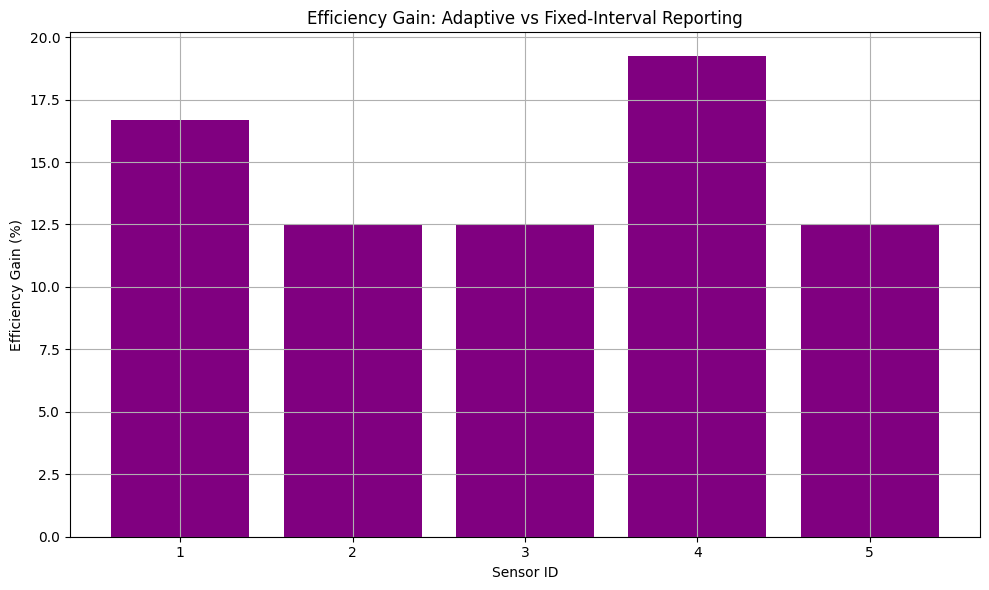

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import radians, cos, sin, sqrt, atan2

# Load the NetCDF data file
file_path = "../data/combined_era5_fort_mcmurray.nc"  # Adjust path as needed
ds = xr.open_dataset(file_path)

# Convert temperature to Celsius
ds["t2m_celsius"] = ds["t2m"] - 273.15

# Define the central hub location (average grid center)
central_lat, central_lon = ds["latitude"].mean().values, ds["longitude"].mean().values

# Haversine formula to compute distance between two latitude-longitude points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of Earth in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2.0) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2.0) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Adaptive reporting logic
def adaptive_reporting(temp):
    """Adaptive temperature reporting logic:
       - Fine granularity (1°C) below 20°C.
       - Coarser granularity (2°C) between 20°C and 30°C.
       - Logarithmic scale at extreme high temperatures (>30°C).
    """
    if temp < 20:
        return round(temp)  # Report to nearest 1°C
    elif 20 <= temp <= 30:
        return round(temp / 2) * 2  # Report to nearest 2°C
    elif temp > 30:
        return round(temp / 5) * 5  # Report to nearest 5°C
    return temp  # Fallback

# Universal Encoding Framework
def universal_encoder(sensor_type, value, min_range, max_range, precision=3):
    """
    Encodes a sensor value into a normalized symbolic representation.
    
    Parameters:
    - sensor_type (str): Type of sensor (e.g., 'temperature', 'light').
    - value (float): Raw sensor reading.
    - min_range (float): Minimum range for normalization.
    - max_range (float): Maximum range for normalization.
    - precision (int): Number of decimal places to retain.
    
    Returns:
    - dict: Encoded value with metadata.
    """
    # Normalize the value into [0, 1]
    normalized_value = round((value - min_range) / (max_range - min_range), precision)
    
    # Metadata to preserve context
    encoded_output = {
        "sensor_type": sensor_type,
        "encoded_value": normalized_value,
        "units": "normalized",
        "raw_value": round(value, precision),
        "range": (min_range, max_range),
        "resolution": precision
    }
    
    return encoded_output

# Function to simulate and encode n sensors
def simulate_and_encode_sensors(n_sensors):
    np.random.seed(42)  # Ensure repeatability
    
    # Randomly generate sensor locations
    latitudes = ds["latitude"].values
    longitudes = ds["longitude"].values
    sensor_locations = [(np.random.choice(latitudes), np.random.choice(longitudes)) for _ in range(n_sensors)]
    
    encoded_reports = []
    report_list = []
    
    for idx, (sensor_lat, sensor_lon) in enumerate(sensor_locations):
        print(f"Processing Sensor {idx + 1}: ({sensor_lat}, {sensor_lon})")
        
        # Extract temperature data for the sensor
        sensor_data = ds["t2m_celsius"].sel(latitude=sensor_lat, longitude=sensor_lon)
        temperature_readings = sensor_data.values
        
        # Encode sensor readings using universal encoder
        for t, temp in enumerate(temperature_readings):
            encoded_value = universal_encoder(
                sensor_type="temperature",
                value=temp,
                min_range=-50,  # Assuming -50°C to 50°C
                max_range=50
            )
            encoded_value["time"] = str(sensor_data["valid_time"].values[t])  # Add timestamp
            encoded_value["Sensor ID"] = idx + 1
            encoded_reports.append(encoded_value)
        
        # Adaptive and fixed reporting
        adaptive_volume = len(set(adaptive_reporting(temp) for temp in temperature_readings)) * 4
        fixed_volume = len(set(round(temp) for temp in temperature_readings)) * 4
        
        # Distance and efficiency
        distance_to_hub = haversine(sensor_lat, sensor_lon, central_lat, central_lon)
        adaptive_efficiency = distance_to_hub / adaptive_volume
        fixed_efficiency = distance_to_hub / fixed_volume
        
        report_list.append({
            "Sensor ID": idx + 1,
            "Latitude": sensor_lat,
            "Longitude": sensor_lon,
            "Adaptive Volume (Bytes)": adaptive_volume,
            "Fixed Volume (Bytes)": fixed_volume,
            "Efficiency Gain (%)": round((fixed_volume - adaptive_volume) / fixed_volume * 100, 2),
            "Adaptive Efficiency (km/Byte)": round(adaptive_efficiency, 6),
            "Fixed Efficiency (km/Byte)": round(fixed_efficiency, 6)
        })
    
    # Return results
    encoded_df = pd.DataFrame(encoded_reports)
    summary_df = pd.DataFrame(report_list)
    return encoded_df, summary_df

# Run the simulation with universal encoding
n_sensors = 5
encoded_results, summary_report = simulate_and_encode_sensors(n_sensors)

# Display results
print("\nUniversal Encoded Outputs:")
print(encoded_results.head())

print("\nSensor Network Summary Report:")
print(summary_report)

# Plot Efficiency Gain
plt.figure(figsize=(10, 6))
plt.bar(summary_report["Sensor ID"], summary_report["Efficiency Gain (%)"], color="purple")
plt.title("Efficiency Gain: Adaptive vs Fixed-Interval Reporting")
plt.xlabel("Sensor ID")
plt.ylabel("Efficiency Gain (%)")
plt.grid()
plt.tight_layout()
plt.show()
